In [1]:
import time
import os
import cv2
import random
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torchvision import models
from torch import optim
from sklearn.metrics import *
from PIL import Image
import shutil

In [2]:
num_workers = 2 #change this parameter based on your system configuration
batch_size = 32 #change this parameter based on your system configuration
seed = 24
random.seed(seed)
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-score']
categories = ['Covid', 'Normal', 'Viral Pneumonia']
num_classes = len(categories)
splits = ['train', 'val', 'test']

In [3]:
DATA_PATH = 'CovidData'

In [4]:
def show_dataset(data_path=DATA_PATH):
    df = pd.DataFrame(columns = ['code'] + splits, index = categories)
    for row in categories:
        for col in splits:
            df.loc[row,col] = int(len(os.listdir(os.path.join(data_path, col+'/'+row))))
    df['total'] = df.sum(axis=1).astype(int)
    df.loc['TOTAL'] = df.sum(axis=0).astype(int)
    df['code'] = ['0', '1', '2','']
    print(df)
    return df
df_dataset = show_dataset()

                code train val test  total
Covid              0   200  25   25    250
Normal             1   200  25   25    250
Viral Pneumonia    2   200  25   25    250
TOTAL                  600  75   75    750


In [5]:
def load_data(data_path=DATA_PATH, num_workers=num_workers):
    transform_dict = {
        'model': transforms.Compose(
                                    [transforms.Resize(299),
                                     transforms.CenterCrop(299),
                                     transforms.ToTensor(),
                                     ])}
    train_data = datasets.ImageFolder(root=data_path + '/train', transform=transform_dict['model'])
    train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=num_workers)
    val_data = datasets.ImageFolder(root=data_path + '/val', transform=transform_dict['model'])
    val_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size, shuffle=False, num_workers=num_workers)
    test_data = datasets.ImageFolder(root=data_path + '/test', transform=transform_dict['model'])
    test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=False, num_workers=num_workers)
    return train_data, train_loader, val_data, val_loader, test_data, test_loader

train_data, train_loader, val_data, val_loader, test_data, test_loader = load_data()
dataset = torch.utils.data.ConcatDataset([train_data, val_data, test_data])

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'You are using {device}')

You are using cpu


Class: Covid


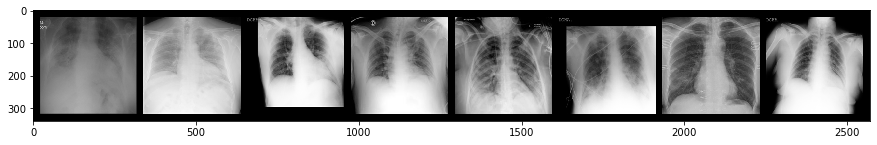

Class: Normal


<Figure size 432x288 with 0 Axes>

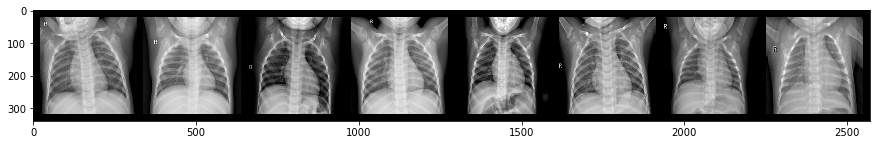

Class: Viral Pneumonia


<Figure size 432x288 with 0 Axes>

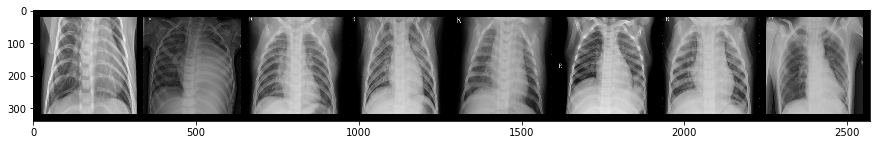

<Figure size 432x288 with 0 Axes>

In [7]:
def show_batch_images(dataset):
    n_images, scale = 8, 3
    data_loader = torch.utils.data.DataLoader(dataset, batch_size=25*n_images, shuffle = True)
    images, labels = next(iter(data_loader))
    for i in range(len(categories)):
        print(f'Class: {categories[i]}')
        images_category = images[labels==i][:n_images]
        grid = torchvision.utils.make_grid(images_category, padding=20)
        npgrid = grid.cpu().numpy()
        plt.figure(figsize=(40*scale/n_images, 20*scale/n_images))
        plt.imshow(np.transpose(npgrid, (1, 2, 0)), interpolation='nearest')
        plt.show()
        plt.savefig('x-ray[i].pdf')  

show_batch_images(train_data)

In [8]:
def calc_metrics(predictions, actuals, row):
    df = pd.DataFrame(columns =metrics)
    Y_pred = np.concatenate(predictions, axis=0)
    Y_test = np.concatenate(actuals, axis=0)
    df.loc[row, 'Accuracy'] = accuracy_score(Y_test, Y_pred)
    df.loc[row, 'Precision'] = precision_score(Y_test, Y_pred, average="macro")
    df.loc[row, 'Recall'] = recall_score(Y_test, Y_pred, average="macro")
    df.loc[row, 'F1-score'] = f1_score(Y_test, Y_pred, average="macro")
    return df

In [9]:
def create_confusion_matrix(preds, y_test):
    ylist, predlist = [], []
    for pred in preds:
        for item in pred:
            predlist.append(int(item))
    for y in y_test:
        for item in y:
            ylist.append(int(item))
    data_dict = {'y_Actual':    ylist, 'y_Predicted': predlist}
    df = pd.DataFrame(data_dict, columns=['y_Actual','y_Predicted'])
    cm = pd.crosstab(df['y_Actual'], df['y_Predicted'], rownames=['ACTUAL'], colnames=['PREDICTED'])
    return cm

In [10]:
def plot_train_val_losses(df):
    df2 = pd.melt(df, id_vars=['epoch'], value_vars=['train', 'val'], var_name='process', value_name='loss')
    sns.lineplot(x = "epoch", y = "loss", data = df2, hue = "process",
                style = "process", palette = "hot", dashes = False, 
                markers = ["o", "<"],  legend="brief").set_title("Train and Validation Losses by Epoch")
    plt.show()

In [11]:
def reset_weights(m):
  for layer in m.children():
   if hasattr(layer, 'reset_parameters'):
    print(f'Reset trainable parameters of layer = {layer}')
    layer.reset_parameters()

In [12]:
def calc_pred_actuals(model, loader):
    predictions, actuals = [], []
    with torch.no_grad():
        for data, target in loader:
            data = data.to(device)
            target = target.to(device)
            Y_pred_orig = model(data)
            _, Y_pred_tag = torch.max(Y_pred_orig, dim = 1)
            Y_pred_tag = Y_pred_tag.detach().cpu().numpy()
            Y_pred_tag = Y_pred_tag.reshape(len(Y_pred_tag), 1).astype('int8')
            Y_test = target.detach().cpu().numpy()
            Y_test = Y_test.reshape(len(Y_test), 1).astype('int8')
            predictions.append(Y_pred_tag)
            actuals.append(Y_test)
    return predictions, actuals

In [13]:
def train_val_model(model):
    t_start = time.time()
    global best_val_model
    global best_val_loss
    best_val_loss = 1
    global best_val_epoch
    best_val_epoch = 0
    df = pd.DataFrame(columns = ['model_name', 'epoch', 'train', 'val'])
    print(f"Training model {model_name} with {df_dataset.loc['TOTAL', 'train']} samples and max of {n_epochs} epochs, and validating with {df_dataset.loc['TOTAL', 'val']} samples\n")
    train_size, val_size = len(train_loader), len(val_loader)
    for epoch in range(1, n_epochs+1):
        # Beginning of training step
        t0 = time.time()
        model.train()
        train_loss, val_loss = 0.0, 0.0
        for i, (data, target) in enumerate(train_loader):
            target = target.to(device)
            data = data.to(device)
            optimizer.zero_grad()
            outputs = model(data)
            loss = criterion(outputs, target)
            loss.backward()
            optimizer.step()
            train_loss += loss.detach().cpu().numpy()
        # Beginning of evaluation step
        model.eval()
        for j, (data, target) in enumerate(val_loader):
            target = target.to(device)
            data = data.to(device)
            outputs = model(data)
            loss = criterion(outputs, target)
            val_loss += loss.detach().cpu().numpy()
        print(f"Epoch {epoch}:\t train loss={train_loss/train_size:.5f} \t val loss={val_loss/val_size:.5f} \t time={(time.time() - t0):.2f}s")
        df.loc[len(df)] = [model_name, epoch, train_loss/train_size, val_loss/val_size]
        if epoch >= best_val_epoch + 15:
            break
        if use_scheduler: scheduler.step(val_loss/val_size)   # Optional to use scheduler for dynamic learning rate
    #print(f"Best model has val loss={best_val_loss:.5f} for {best_val_epoch} epochs")
    print(f"Total time training and evaluating: {(time.time()-t_start):.2f}s")
    return model, df

In [14]:
def train_val_model_kfold(model, train_loader_kfold):
    t_start = time.time()
    df = pd.DataFrame(columns = ['model_name', 'epoch', 'train'])
    print(f"Training model {model_name} with {df_dataset.loc['TOTAL', 'train']} samples and max of {n_epochs} epochs")
    train_size = len(train_loader_kfold)
    for epoch in range(1, n_epochs+1):
        # Beginning of training step
        t0 = time.time()
        #model.train()
        train_loss = 0.0
        for i, (data, target) in enumerate(train_loader_kfold):
            target = target.to(device)
            data = data.to(device)
            optimizer.zero_grad()
            outputs = model(data)
            loss = criterion(outputs, target)
            loss.backward()
            optimizer.step()
            train_loss += loss.detach().cpu().numpy()
        print(f"Epoch {epoch}:\t train loss={train_loss/train_size:.5f} \t time={(time.time() - t0):.2f}s")
        df.loc[len(df)] = [model_name, epoch, train_loss/train_size]
    print(f"Total time training and evaluating: {(time.time()-t_start):.2f}s")
    return model, df

In [15]:
def accuracy_model(model, loader):
    model.eval()
    print(f"Testing the model {model_name} with {df_dataset.loc['TOTAL', 'test']} samples \n")   
    predictions, actuals = calc_pred_actuals(model, loader)
    conf_matrix = create_confusion_matrix(predictions, actuals)
    df_test = calc_metrics(predictions, actuals, 'Test Results').astype(float)
    print(df_test)
    return df_test, conf_matrix

In [16]:
def initialize_model(model_name, num_classes, use_pretrained=True):
    model_ft = models.vgg19_bn(pretrained=use_pretrained)
    for param in model_ft.parameters():
        param.requires_grad = False
    num_ftrs = model_ft.classifier[6].in_features
    model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
    
    model_ft.to(device)
    return model_ft

In [17]:
vgg19_model = initialize_model("vgg19", num_classes, use_pretrained=True)

Downloading: "https://download.pytorch.org/models/vgg19_bn-c79401a0.pth" to C:\Users\LENOVO/.cache\torch\hub\checkpoints\vgg19_bn-c79401a0.pth


  0%|          | 0.00/548M [00:00<?, ?B/s]

In [18]:
np.random.seed(seed)
torch.manual_seed(seed)
model_name = 'VGG19'
n_epochs = 20
learning_rate = 1e-2
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(vgg19_model.parameters(), lr=learning_rate)
use_scheduler = False   # Set True if using scheduler
pretrained_model, df_vgg19_epochs = train_val_model(vgg19_model)

Training model VGG19 with 600 samples and max of 20 epochs, and validating with 75 samples

Epoch 1:	 train loss=0.86931 	 val loss=0.81359 	 time=579.71s
Epoch 2:	 train loss=0.62731 	 val loss=0.66008 	 time=571.14s
Epoch 3:	 train loss=0.54128 	 val loss=0.52045 	 time=561.98s
Epoch 4:	 train loss=0.48969 	 val loss=0.39156 	 time=564.65s
Epoch 5:	 train loss=0.46316 	 val loss=0.41853 	 time=570.26s
Epoch 6:	 train loss=0.44365 	 val loss=0.32824 	 time=565.79s
Epoch 7:	 train loss=0.40320 	 val loss=0.37326 	 time=566.29s
Epoch 8:	 train loss=0.40662 	 val loss=0.35259 	 time=568.41s
Epoch 9:	 train loss=0.37633 	 val loss=0.33334 	 time=437.36s
Epoch 10:	 train loss=0.37809 	 val loss=0.33148 	 time=427.49s
Epoch 11:	 train loss=0.34956 	 val loss=0.28797 	 time=458.63s
Epoch 12:	 train loss=0.34721 	 val loss=0.29157 	 time=486.70s
Epoch 13:	 train loss=0.35212 	 val loss=0.29222 	 time=546.79s
Epoch 14:	 train loss=0.38365 	 val loss=0.32772 	 time=469.95s
Epoch 15:	 train loss

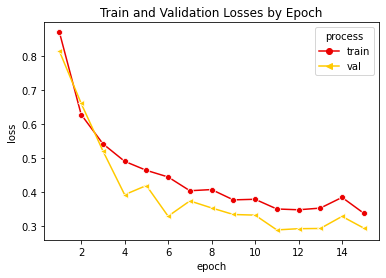

In [19]:
plot_train_val_losses(df_vgg19_epochs)

In [20]:
test_vgg19_results, conf_vgg19_matrix_test = accuracy_model(pretrained_model, test_loader)

Testing the model VGG19 with 75 samples 

              Accuracy  Precision    Recall  F1-score
Test Results  0.866667   0.877513  0.866667  0.865856


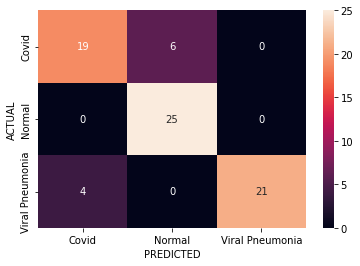

In [21]:
_ = sns.heatmap(conf_vgg19_matrix_test, annot=True, fmt='g', xticklabels=categories, yticklabels=categories)

In [22]:
from sklearn.model_selection import KFold
def validate_model_kfold(model, model_name, k_folds):
    #model.eval()
    print(f"Validating the model {model_name} with {df_dataset.loc['TOTAL', 'train']} samples and {k_folds}-folds \n")
    df = pd.DataFrame(columns = metrics)
    kfold = KFold(n_splits=k_folds, shuffle=True)
    print(len(dataset))
    for fold, (train_ids, test_ids) in enumerate(kfold.split(dataset)):
        train_subsampler = torch.utils.data.SubsetRandomSampler(train_ids)
        test_subsampler = torch.utils.data.SubsetRandomSampler(test_ids)
        train_kfold_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, num_workers=num_workers, sampler=train_subsampler)
        test_kfold_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, num_workers=num_workers, sampler=test_subsampler)
        #model.apply(reset_weights)
        model, df_vgg_epochs = train_val_model_kfold(model, train_kfold_loader)
        predictions, actuals = calc_pred_actuals(model, test_kfold_loader)
        conf_matrix = create_confusion_matrix(predictions, actuals)
        df_aux = calc_metrics(predictions, actuals, 'FOLD '+str(fold+1))
        df = df.append(df_aux)      
    df.loc['Average'] = df.mean(axis=0)
    print(df.astype(float))
    return df.astype(float), conf_matrix

In [23]:
validation_our_model_results, conf_matrix_our_model_val = validate_model_kfold(vgg19_model, model_name = 'VGG19', k_folds = 5)

Validating the model VGG19 with 600 samples and 5-folds 

750
Training model VGG19 with 600 samples and max of 20 epochs
Epoch 1:	 train loss=0.28136 	 time=492.35s
Epoch 2:	 train loss=0.27473 	 time=370.24s
Epoch 3:	 train loss=0.26187 	 time=318.74s
Epoch 4:	 train loss=0.25139 	 time=331.02s
Epoch 5:	 train loss=0.24940 	 time=332.60s
Epoch 6:	 train loss=0.23723 	 time=336.77s
Epoch 7:	 train loss=0.22921 	 time=337.98s
Epoch 8:	 train loss=0.22151 	 time=333.52s
Epoch 9:	 train loss=0.21927 	 time=343.00s
Epoch 10:	 train loss=0.21332 	 time=331.84s
Epoch 11:	 train loss=0.20774 	 time=335.18s
Epoch 12:	 train loss=0.20218 	 time=334.28s
Epoch 13:	 train loss=0.19690 	 time=331.82s
Epoch 14:	 train loss=0.19364 	 time=335.35s
Epoch 15:	 train loss=0.18848 	 time=335.01s
Epoch 16:	 train loss=0.18455 	 time=333.41s
Epoch 17:	 train loss=0.18058 	 time=336.00s
Epoch 18:	 train loss=0.17809 	 time=333.22s
Epoch 19:	 train loss=0.17414 	 time=335.76s
Epoch 20:	 train loss=0.17172 	 t